<a href="https://colab.research.google.com/github/signofcommunication/Tugas-Matana-University/blob/master/Lipstick_Enhancement_Fiola_Arta_Gloria_Saranani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install mediapipe opencv-python matplotlib numpy

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Upload gambar wajah (format JPG/PNG):


Saving WhatsApp Image 2025-12-01 at 10.59.34_6ab02691.jpg to WhatsApp Image 2025-12-01 at 10.59.34_6ab02691.jpg
[DEBUG] Analisis Bibir -> H:27.7, S:112.6, V:160.5, DarkRatio:4.4%
-> Terdeteksi: Bibir Merah

>>> REKOMENDASI FINAL: Baby Pink <<<
Warna RGB: (250, 183, 174)


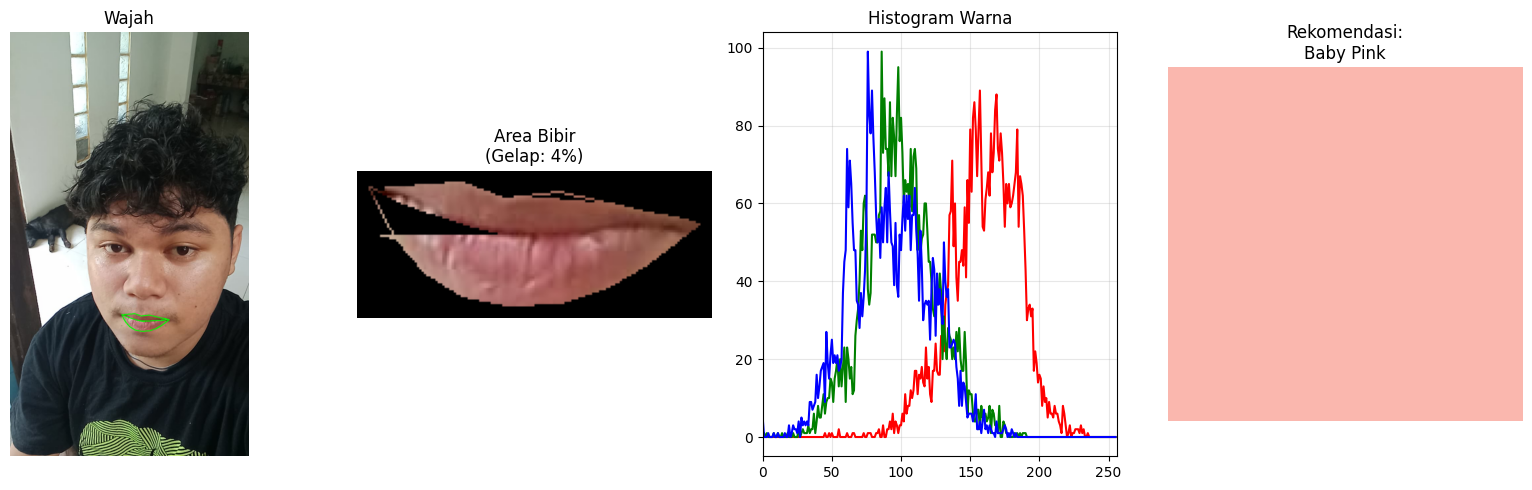

In [26]:
# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

# Define lip landmarks indices
LIP_LANDMARKS = [
    61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 409, 270, 269, 267, 0, 37, 39, 40, 185, # Outer
    78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 415, 310, 311, 312, 13, 82, 81, 80, 191  # Inner
]

def analyze_lip_color(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        raise ValueError("No face detected in the image.")

    face_landmarks = results.multi_face_landmarks[0]
    height, width, _ = image.shape

    # 1. Get Landmarks & Extract Lip
    lip_points = []
    for idx in LIP_LANDMARKS:
        lm = face_landmarks.landmark[idx]
        x = int(lm.x * width)
        y = int(lm.y * height)
        lip_points.append((x, y))

    # Masking
    lip_mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillConvexPoly(lip_mask, np.array(lip_points), 255)

    # Cropping
    rect = cv2.boundingRect(np.array(lip_points))
    x, y, w, h = rect
    padding = 5
    x, y = max(0, x - padding), max(0, y - padding)
    w, h = min(width - x, w + 2*padding), min(height - y, h + 2*padding)

    cropped_image = image[y:y+h, x:x+w]
    cropped_mask = lip_mask[y:y+h, x:x+w]
    lip_extracted = cv2.bitwise_and(cropped_image, cropped_image, mask=cropped_mask)

    # 2. Compute Stats
    lip_hsv = cv2.cvtColor(lip_extracted, cv2.COLOR_BGR2HSV)
    valid_pixels_hsv = lip_hsv[cropped_mask > 0]

    if len(valid_pixels_hsv) == 0:
        raise ValueError("No valid lip pixels found.")

    mean_hsv = np.mean(valid_pixels_hsv, axis=0)

    # Hitung rasio gelap (untuk mengatasi flash)
    pixel_values = valid_pixels_hsv[:, 2] # Channel V
    dark_pixel_count = np.sum(pixel_values < 115)
    total_pixels = len(pixel_values)
    dark_ratio = dark_pixel_count / total_pixels

    return mean_hsv, dark_ratio, lip_points, lip_extracted, cropped_mask

# --- RULES SYSTEM (UPDATED SESUAI PERMINTAAN) ---
lipstick_rules = {
    # KONDISI 1: Bibir Hitam/Gelap -> Rekomendasi "Nude"
    'kondisi_hitam': {
        # Logic: Value rendah atau Rasio gelap tinggi
        'check': lambda h, s, v, ratio: v < 100 or ratio > 0.30,
        'rec': 'Nude',
        'rgb': (247, 189, 159) # Warna Peach/Nude
    },

    # KONDISI 2: Bibir Baby Pink (Pucat/Soft) -> Rekomendasi "Light Pink"
    'kondisi_pucat': {
        # Logic: Saturasi rendah
        'check': lambda h, s, v, ratio: s < 110,
        'rec': 'Light Pink',
        'rgb': (200, 60, 69) # Warna Merah Gelap/Deep Pink
    },

    # KONDISI 3: Bibir Merah (Normal) -> Rekomendasi "Baby Pink"
    'kondisi_merah': {
        # Logic: Fallback (Saturasi tinggi dan tidak gelap)
        'check': lambda h, s, v, ratio: True,
        'rec': 'Baby Pink',
        'rgb': (250, 183, 174) # Warna Pink Lembut
    }
}

def get_lipstick_recommendation(mean_hsv, dark_ratio):
    h, s, v = mean_hsv
    print(f"[DEBUG] Analisis Bibir -> H:{h:.1f}, S:{s:.1f}, V:{v:.1f}, DarkRatio:{dark_ratio*100:.1f}%")

    # 1. Cek Bibir Hitam
    if lipstick_rules['kondisi_hitam']['check'](h, s, v, dark_ratio):
        print("-> Terdeteksi: Bibir Hitam (Gelap)")
        return lipstick_rules['kondisi_hitam']['rec'], lipstick_rules['kondisi_hitam']['rgb']

    # 2. Cek Bibir Baby Pink (Pucat)
    if lipstick_rules['kondisi_pucat']['check'](h, s, v, dark_ratio):
        print("-> Terdeteksi: Bibir Baby Pink (Pucat/Soft)")
        return lipstick_rules['kondisi_pucat']['rec'], lipstick_rules['kondisi_pucat']['rgb']

    # 3. Default: Bibir Merah
    print("-> Terdeteksi: Bibir Merah")
    return lipstick_rules['kondisi_merah']['rec'], lipstick_rules['kondisi_merah']['rgb']

def draw_lip_detection(image, lip_points):
    image_copy = image.copy()
    cv2.polylines(image_copy, [np.array(lip_points)], isClosed=True, color=(0, 255, 0), thickness=2)
    return image_copy

# Main execution
def main():
    print("Upload gambar wajah (format JPG/PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("Tidak ada gambar yang diupload.")
        return

    file_name = next(iter(uploaded))
    image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_COLOR)

    try:
        mean_hsv, dark_ratio, lip_points, extracted_lip, cropped_mask = analyze_lip_color(image)
        recommendation, color_rgb = get_lipstick_recommendation(mean_hsv, dark_ratio)

        # Output Text Console
        print(f"\n>>> REKOMENDASI FINAL: {recommendation} <<<")
        print(f"Warna RGB: {color_rgb}")

        detected_image = draw_lip_detection(image, lip_points)
        extracted_lip_rgb = cv2.cvtColor(extracted_lip, cv2.COLOR_BGR2RGB)

        # Plotting
        plt.figure(figsize=(16, 5))

        # 1. Wajah
        plt.subplot(1, 4, 1)
        plt.title("Wajah")
        plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # 2. Bibir
        plt.subplot(1, 4, 2)
        plt.title(f"Area Bibir\n(Gelap: {dark_ratio*100:.0f}%)")
        plt.imshow(extracted_lip_rgb)
        plt.axis('off')

        # 3. Histogram
        plt.subplot(1, 4, 3)
        plt.title("Histogram Warna")
        colors = ('r', 'g', 'b')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([extracted_lip_rgb], [i], cropped_mask, [256], [0, 256])
            plt.plot(hist, color=color)
        plt.xlim([0, 256])
        plt.grid(alpha=0.3)

        # 4. Rekomendasi (Warna dan Text Sesuai Request)
        color_swatch = np.zeros((100, 100, 3), dtype=np.uint8)

        # Note: Matplotlib membaca RGB, dan input Anda sudah RGB. Jadi langsung dimasukkan.
        color_swatch[:, :] = color_rgb

        plt.subplot(1, 4, 4)
        plt.title(f"Rekomendasi:\n{recommendation}")
        plt.imshow(color_swatch) # Display RGB swatch
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Error: {e}")

main()